In [0]:
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

%tensorflow_version 2.x
import tensorflow as tf

import numpy as np
import base64, io, time, gym
import IPython, functools
import matplotlib.pyplot as plt
from tqdm import tqdm

!pip install mitdeeplearning
import mitdeeplearning as mdl

In [0]:
### Instantiate the Cartpole environment ###

env = gym.make("CartPole-v0")
env.seed(1)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[1]

In [0]:
n_observations = env.observation_space
print("Environment has observation space =", n_observations)
# action = np.expand_dims(n_actions, axis=0)
# print(observation)

Environment has observation space = Box(4,)


In [0]:
n_actions = env.action_space
print("Number of possible actions that the agent can choose from =", n_actions)
action = np.expand_dims(env.action_space, axis=0)
print(action[0])

Number of possible actions that the agent can choose from = Discrete(2)
Discrete(2)


In [0]:
### Define the Cartpole agent ###

# Defines a feed-forward neural network
def create_cartpole_model():
  model = tf.keras.models.Sequential([
      # First Dense layer
      tf.keras.layers.Dense(units=32, activation='relu'),
      
      tf.keras.layers.Dense(units=2,activation='sigmoid')
  ])
  return model

cartpole_model = create_cartpole_model()

In [0]:
### Define the agent's action function ###

# Function that takes observations as input, executes a forward pass through model, 
#   and outputs a sampled action.
# Arguments:
#   model: the network that defines our agent
#   observation: observation which is fed as input to the model
# Returns:
#   action: choice of agent action
def choose_action(model, observation):
  # add batch dimension to the observation
  observation = np.expand_dims(observation, axis=0)

  logits = model.predict(observation)
  
  # pass the log probabilities through a softmax to compute true probabilities
  prob_weights = tf.nn.softmax(logits).numpy()
  # print('observation',observation)
  # print('logits',logits)
  # print('p_w',prob_weights)
  
  actions = np.expand_dims(env.action_space, axis=0)
  action = np.random.choice(2, size=1, p=prob_weights[0])
  action=np.int(action)
  return action

In [0]:
### Agent Memory ###

class Memory:
  def __init__(self): 
      self.clear()

  # Resets/restarts the memory buffer
  def clear(self): 
      self.observations = []
      self.actions = []
      self.rewards = []

  # Add observations, actions, rewards to memory
  def add_to_memory(self, new_observation, new_action, new_reward): 
      self.observations.append(new_observation)
      self.actions.append(new_action)
      self.rewards.append(new_reward)

        
memory = Memory()

In [0]:
### Reward function ###

# Helper function that normalizes an np.array x
def normalize(x):
  x -= np.mean(x)
  x /= np.std(x)
  return x.astype(np.float32)

# Compute normalized, discounted, cumulative rewards (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.95): 
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
      # update the total discounted reward
      R = R * gamma + rewards[t]
      discounted_rewards[t] = R
      

  return normalize(discounted_rewards)

In [0]:
### Loss function ###

# Arguments:
#   logits: network's predictions for actions to take
#   actions: the actions the agent took in an episode
#   rewards: the rewards the agent received in an episode
# Returns:
#   loss
def compute_loss(logits, actions, rewards): 
  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
  
  loss = tf.reduce_mean(rewards*neg_logprob)
  return loss

In [0]:
### Training step (forward and backpropagation) ###

def train_step(model, optimizer, observations, actions, discounted_rewards):
  with tf.GradientTape() as tape:
      # Forward propagate through the agent network
      logits = model(observations)
      # print(observations)
      # print('1')
      # print(logits)
      loss = compute_loss(logits,actions,discounted_rewards)
      # print('2')
  grads = tape.gradient(loss, model.trainable_variables)
  # print('3')
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  # print('4')

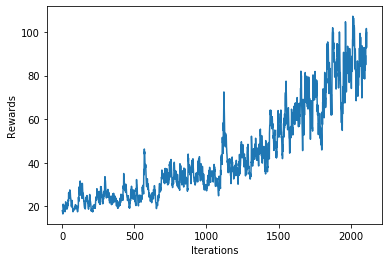

In [0]:
### Cartpole training! ###

# Learning rate and optimizer
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

# instantiate cartpole agent
cartpole_model = create_cartpole_model()

# to track our progress
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i_episode in range(3300):

  plotter.plot(smoothed_reward.get())

  # Restart the environment
  observation = env.reset()
  memory.clear()

  while True:
      # using our observation, choose an action and take it in the environment
      action = choose_action(cartpole_model, observation)
      next_observation, reward, done, info = env.step(action)
      # add to memory
      memory.add_to_memory(observation, action, reward)
      
      # is the episode over? did you crash or do so well that you're done?
      if done:
          # determine total reward and keep a record of this
          total_reward = sum(memory.rewards)
          smoothed_reward.append(total_reward)
          
          # initiate training - remember we don't know anything about how the 
          #   agent is doing until it has crashed!
          train_step(cartpole_model, optimizer, 
                     observations=np.vstack(memory.observations),
                     actions=np.array(memory.actions),
                     discounted_rewards = discount_rewards(memory.rewards))
          
          # reset the memory
          memory.clear()
          break
      # update our observatons
      observation = next_observation

In [0]:
saved_cartpole = mdl.lab3.save_video_of_model(cartpole_model, "CartPole-v0")
mdl.lab3.play_video(saved_cartpole)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Successfully saved 44 frames into CartPole-v0.mp4!
